# Frangi Vesselness Measure/Filter

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Show/Hide Code</a>.

In [1]:
%run "002_frangi_comparisons_shared.ipynb"

---Image Stats---
 Shape: (400, 200, 3) 
 Type: <class 'numpy.ndarray'> 
 Mean: 117.71827916666666 
 Median: 82.0 
 Max: 244 
 Min: 14 


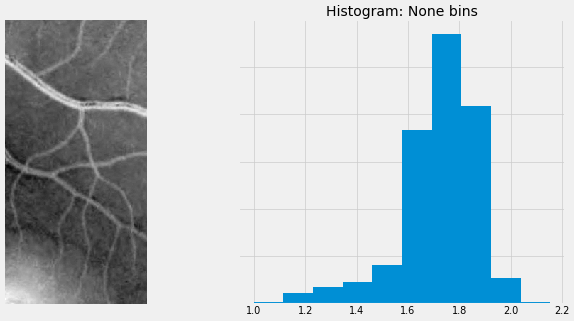

In [2]:
img = SrcImage("media/mraneck2.jpeg")
img.show_with_hist()
print(img.stats)

## Frangi Vs Hessian-based Ridge Operators
**Package:** `skimage` 

Compare with

- `sato` Same as Frangi only that it does not use all the eigenvalues at the same time 
- `meijering` Similarity to neurites 

**Results**
- `Sato` has a little background noise left and it's vessel signal or contrast is lower
- `Meijering` has strong vessel signal/contrast and has background noise


In [3]:
def run_filter_operators(img, filterz, filter_namez, paramz, ibase=None, ibasename=None):
    outsiez = [] if ibase is None else [ibase]    
    for filt, lbl in zip( filterz, filter_namez):
        f = AFilter( filt, paramz, lbl)
        outsiez.append( f.apply(img))
        
    t = filter_namez if ibase is None else ['frangi' if ibasename is None else ibasename, *filter_namez]
    show_image_list(outsiez, titlez=t, nc=len(outsiez))
    return outsiez 

def run_mashup(img, base, base_name, filterz, filter_namez, paramz, 
               ibase=None, ibasename=None, base_paramz={},
              addback=False):
    base_res = AFilter(base, base_paramz, base_name) 
    base_img = base_res.apply(img)

    reportez = []
    diff_reportez = []
    outsiez = [] if ibase is None else [ibase]   
    titlez = ['frangi'] if ibasename is None else [ibasename]   
    def run_operator(operator, name, sym):
        d = "="
        reportez.append(f"{d*4} {name} operation Mashup {d*4}")
        for filt, lbl in zip( filterz, filter_namez):
            fi = AFilter( filt, paramz, lbl).apply(img)
            f = operator(  [fi ], show=False)
            if addback:
                f = f + fi
            outsiez.append( f )
            diff_reportez.append( *base_res.compare_diff( [f] , show=False) )
            reportez.append( base_res.compare_stats([f], img_titlez=[lbl], show=False) )
            titlez.append( f"{base_name} {sym} {lbl}" ) #titlez + [f"{base_name} {sym} {x}" for x in filter_namez]
    
    run_operator(base_res.product_mash, 'Product', '*' )    
    outsiez2 = outsiez.copy() 
    run_operator(base_res.subtract_mash, 'Sum' , "+")
    
    print(f"{base_name} mashup Images")    
    show_image_list( outsiez,  titlez=titlez, nc=len(outsiez))
    plt.clf();
    print("Compare Diff Images")
    show_image_list( diff_reportez, titlez=titlez, nc=len(outsiez))
    plt.show(); 
    
    print( "\n".join( reportez))
    return outsiez2
    
    

In [4]:
sigmaz = range(0,10,1) #[ x/10 for x in range(4,100,2)]
paramz = {'sigmas':sigmaz, 'black_ridges':0 }
gray_smoothed_img = img.denoised(sig=7) 

In [5]:
#paramz = {'sigmas':sigmaz, 'black_ridges':0 }
ifrangi = AFilter( skfilters.frangi, paramz, 'lbl', mode=-1).apply(img.gray_float_array)

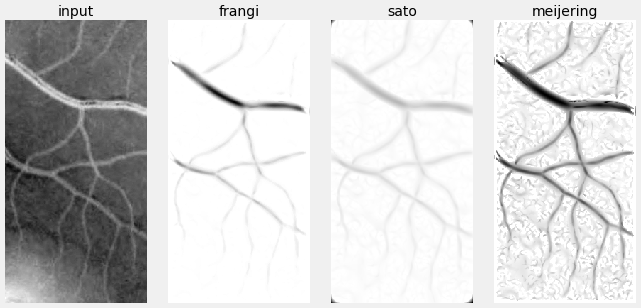

In [6]:
filterz = [skfilters.frangi, skfilters.sato, skfilters.meijering]
labelz =['frangi', 'sato', 'meijering']
inimg = img.gray_float_array
origi_ridgez = run_filter_operators(inimg, filterz, labelz, paramz, ibase=inimg, ibasename='input')

### Mashup Meijering with Frangi and Sato
because it has stronger vessel signal but very poor backgrou suppression

meijering mashup Images


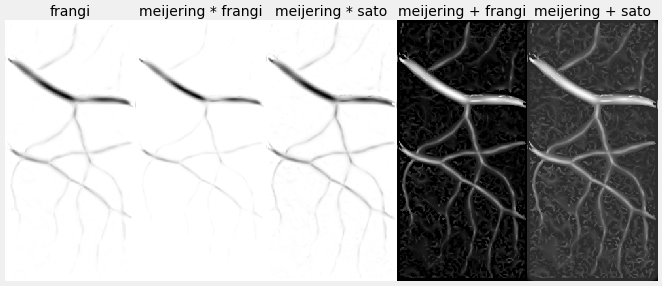

Compare Diff Images


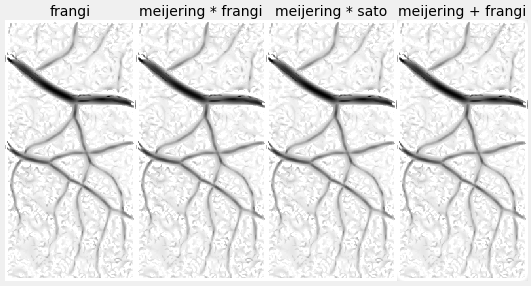

==== Product operation Mashup ====
MSE: (meijering - frangi) 	0.0343 	-0.0 	-0.1042
MSE: (meijering - sato) 	0.0325 	-0.0016 	-0.1042
==== Sum operation Mashup ====
MSE: (meijering - frangi) 	0.1374 	0.1042 	-0.1042
MSE: (meijering - sato) 	0.131 	0.0989 	-0.1042


In [7]:
masherz = [skfilters.frangi, skfilters.sato,]
masherz_labelz =['frangi', 'sato', ]
mashup_ridgez = run_mashup(img.gray_float_array, 
           skfilters.meijering, 'meijering', 
           masherz, masherz_labelz, 
           paramz, base_paramz=paramz,
           ibase=ifrangi)

1. No mashup


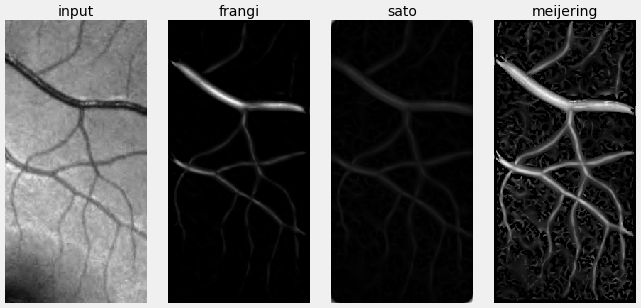

2. Yes mashup


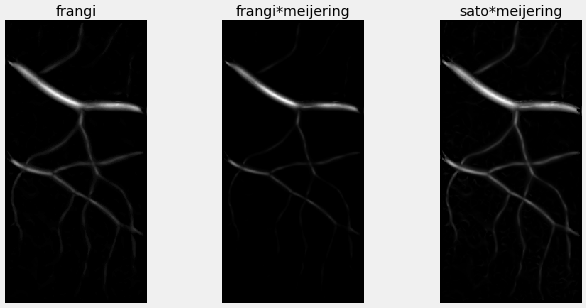

In [8]:
src = img.gray_float_array 
tz =['input','frangi', 'sato', 'meijering']
print("1. No mashup")
outsiez = [ src*x for x in origi_ridgez]
show_image_list(outsiez, titlez=tz, nc=len(outsiez))
plt.clf();

print("2. Yes mashup")
tz =['frangi','frangi*meijering', 'sato*meijering', ]
outsiez = [ src*x for x in mashup_ridgez]
show_image_list(outsiez, titlez=tz, nc=len(outsiez))
plt.show();

----
## Frangi Vs Edge Detectors


**Results**
- Edge detectors are not distinguishing the background from the foreground (vessels)
- Smoothing helps with background noise but still messy/noisy/blurry edges 

Small smoothing sigma value


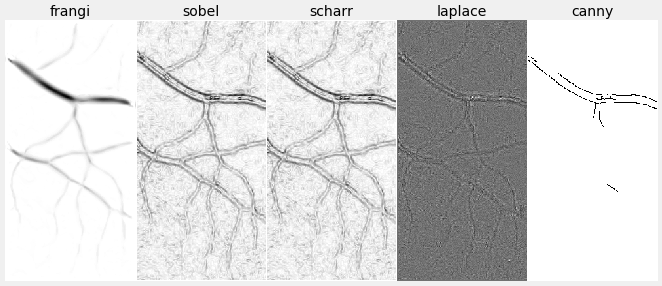

In [9]:

gray_smoothed_img = img.denoised(sig=0.01) 
edge_paramz = {}

filterz = [skfilters.sobel, skfilters.scharr, skfilters.laplace, skimage.feature.canny]
labelz =['sobel', 'scharr', 'laplace', 'canny']

print("Small smoothing sigma value")
rel_edgez = run_filter_operators(gray_smoothed_img, filterz, labelz, edge_paramz, ibase=ifrangi)

Large smoothing sigma value


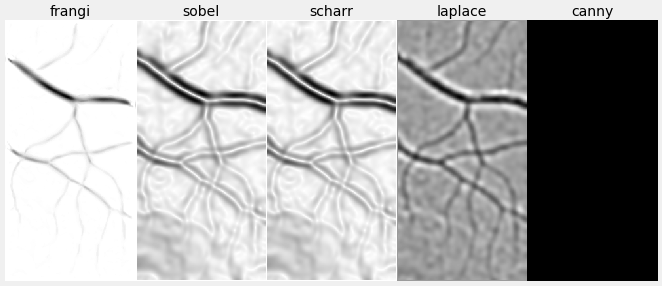

In [10]:
print("Large smoothing sigma value")
gray_smoothed_img = img.denoised(sig=5) 
smothed_edgez = run_filter_operators(gray_smoothed_img, filterz, labelz, edge_paramz, ibase=ifrangi)

1. Small smoothing


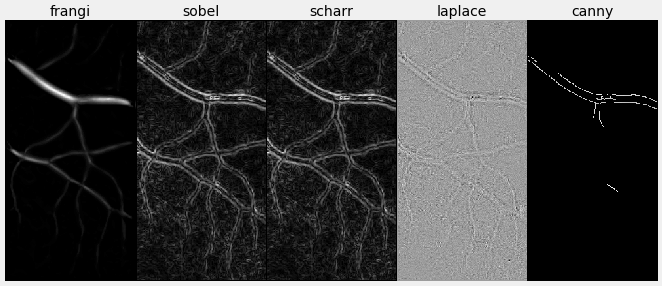

2. Large smoothing


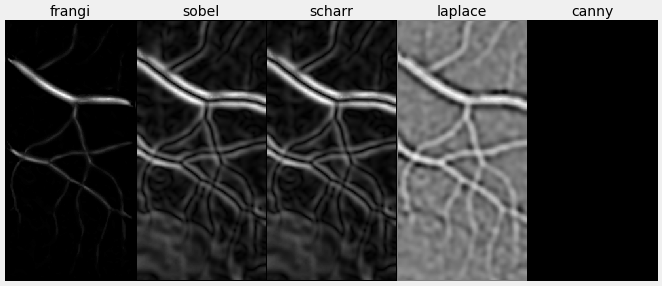

In [11]:
src = img.gray_float_array 
tz = ['frangi', *labelz] 
print("1. Small smoothing")
outsiez = [ src*x for x in rel_edgez]
show_image_list(outsiez, titlez=tz, nc=len(outsiez))
plt.clf();

print("2. Large smoothing")
outsiez = [src*x for x in smothed_edgez]
show_image_list(outsiez, titlez=tz, nc=len(outsiez))
plt.show(); 

### Frangi , Sato Mashup with an edge detector


laplace mashup Images


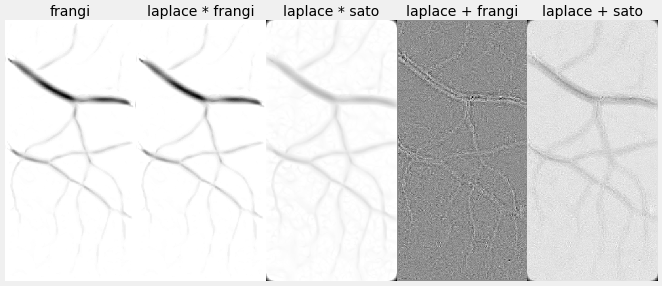

Compare Diff Images


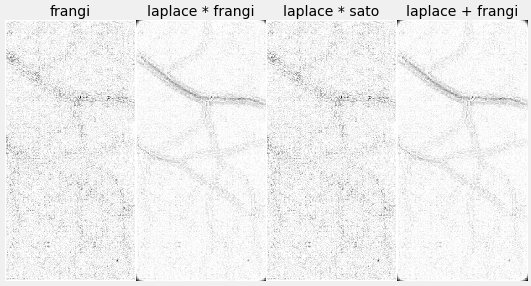

==== Product operation Mashup ====
MSE: (laplace - frangi) 	0.0001 	-0.0 	0.0
MSE: (laplace - sato) 	0.0002 	-0.0053 	0.0
==== Sum operation Mashup ====
MSE: (laplace - frangi) 	0.0004 	-0.0 	0.0
MSE: (laplace - sato) 	0.0007 	-0.0106 	0.0


In [12]:
masherz = [skfilters.frangi, skfilters.sato,]
masherz_labelz =['frangi', 'sato', ]
x = run_mashup(img.gray_float_array, 
           skfilters.laplace, 'laplace', 
           masherz, masherz_labelz, 
           paramz, ibase=ifrangi, 
           addback=True)

scharr mashup Images


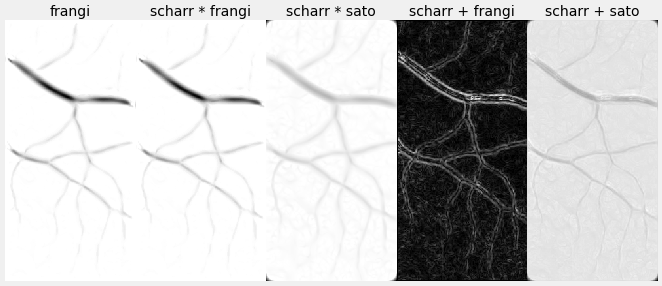

Compare Diff Images


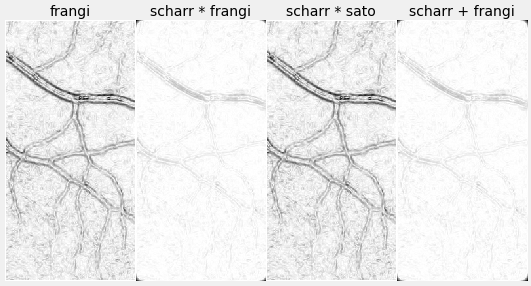

==== Product operation Mashup ====
MSE: (scharr - frangi) 	0.0001 	-0.0 	-0.007600000128149986
MSE: (scharr - sato) 	0.0001 	-0.0053 	-0.007600000128149986
==== Sum operation Mashup ====
MSE: (scharr - frangi) 	0.0004 	0.0076 	-0.007600000128149986
MSE: (scharr - sato) 	0.0003 	-0.0029 	-0.007600000128149986


In [13]:
masherz = [skfilters.frangi, skfilters.sato,]
masherz_labelz =['frangi', 'sato', ]
x = run_mashup(img.gray_float_array, 
           skfilters.scharr, 'scharr', 
           masherz, masherz_labelz, 
           paramz, ibase=ifrangi,
           addback=True)

## Frangi Vs Morphological Operators

**Loosely** 
1. denoise and binary threshold 
2. shrink out small things --> erode with large size
3. expand what should be desired things --> dilate with size smaller than erode? 

**Approach and Structuring element choice**
[This Paper, 2014](https://www.researchgate.net/publication/269291825_Blood_vessel_extraction_using_morphological_operation_for_Diabetic_Retinopathy) 

- Steps:
    - two parallel processes: 1 for peaks and another for valleys  
    - input image is on green channel
        - Valley detection operates on the green channel as is
        - Peak detection operats on inversion of the green channel 
    - Meidan filtering to smooth 
    - Morphological processing
        - Valley detection: closing morphology 
        - Peak detection: opening morphology 
    - Image impose/recombine 
        - binary thresholding based on if is $valley or peak = 255$ else$=0$


- Structuring Element: uses a half-sphere structure 
    - Peak detection morphological processing works with `circle`, `sphere` and `square` elements 
        - Peaks are local maximum. Problem is that peaks can overlap
        - It's an `opening` morphology
    - Valley Detection works with 
        - It's a `closing morphology 
        
**Mashups**
1. Combine with edge detectors before or after 
2. 

In [14]:
def run_morphological(smoothed, dsize):
    struct_element = skimage.morphology.disk(dsize)
    valleyz = skimage.morphology.closing(smoothed, selem=struct_element)
    valleyz = valleyz - median_img
    peakz = skimage.morphology.opening(median_img, selem=struct_element)
    peakz = peakz - median_img

    outsiez = valleyz + peakz 
    outsiez = outsiez > skfilters.threshold_otsu(outsiez)
#     outsiez = outsiez > skfilters.threshold_yen(outsiez)
#     outsiez = outsiez > skfilters.threshold_local(outsiez,3)*-1
#     outsiez = outsiez > skfilters.threshold_local(outsiez,13, method='gaussian')*-1
    # def join_impose(valley, peak):
    return outsiez*-1
    

# show_image_list([img.gray_float_array, median_img, valleyz, peakz, outsiez], 
#                 titlez=['src', 'smooth', 'valleyz', 'peakz', 'res'],nc=5)



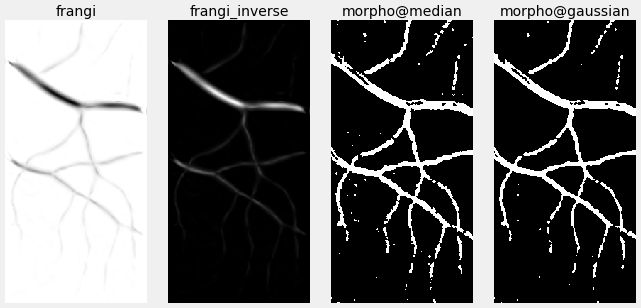

In [15]:
median_img = skfilters.median( img.gray_float_array )
gauss_img = skfilters.gaussian( img.gray_float_array , sigma=7)

outsiez_m = run_morphological( median_img, dsize=7)
outsiez_g = run_morphological( gauss_img, dsize=7)

show_image_list([ifrangi, ifrangi*-1, outsiez_m, outsiez_g],
               titlez=['frangi', 'frangi_inverse','morpho@median', 'morpho@gaussian'], nc=4)

In [16]:
def run_morphological(img, smoother, dsize):
    
    green_img = img[:, :, 1]
    
    smoothed = smoother[0](green_img, **smoother[1])
    struct_element = skimage.morphology.disk(dsize)
    valleyz = skimage.morphology.closing(smoothed, selem=struct_element)
    valleyz = valleyz - median_img
    
    smoothed = smoother[0](green_img*-1, **smoother[1])
    peakz = skimage.morphology.opening(median_img, selem=struct_element)
    peakz = peakz - median_img

    outsiez = valleyz * peakz 
    outsiez = outsiez > skfilters.threshold_otsu(outsiez)
#     outsiez = outsiez > skfilters.threshold_yen(outsiez)
#     outsiez = outsiez > skfilters.threshold_local(outsiez,3)*-1
#     outsiez = outsiez > skfilters.threshold_local(outsiez,13, method='gaussian')*-1
    # def join_impose(valley, peak):
    return outsiez*-1 



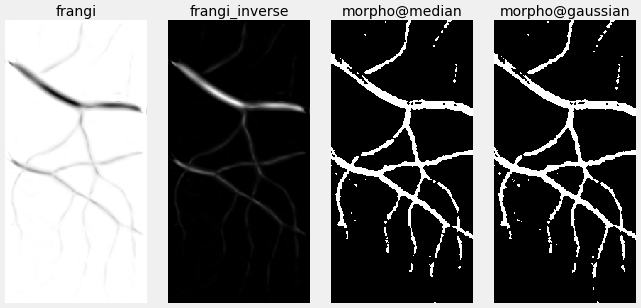

In [17]:
img_colr = img.img

smoother = (skfilters.median, { })
outsiez_m = run_morphological( img_colr, smoother, dsize=7)

smoother = (skfilters.gaussian, {'sigma':7})
outsiez_g = run_morphological(img_colr, smoother, dsize=7)

show_image_list([ifrangi, ifrangi*-1, outsiez_m, outsiez_g],
               titlez=['frangi', 'frangi_inverse','morpho@median', 'morpho@gaussian'], nc=4)

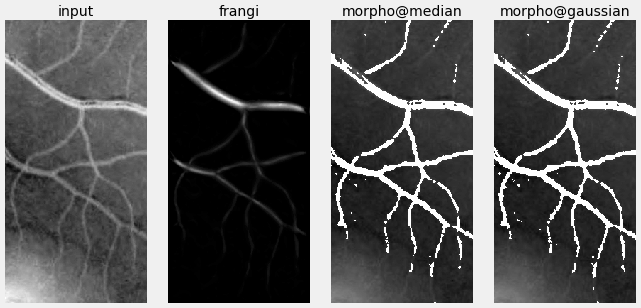

In [18]:
src = img.gray_float_array 
tz = ['input','frangi', 'morpho@median', 'morpho@gaussian'] 
morphed = [ifrangi, outsiez_m*-1, outsiez_g*-1]
# print("1. Small smoothing")
outsiez = [ src*x for x in morphed]
show_image_list([img.gray_float_array,*outsiez], titlez=tz, nc=len(outsiez)+1)
plt.show();


In [19]:
# img_colr = img.img_full

# smoother = (skfilters.median, { })
# outsiez_m = run_morphological( img_colr, smoother, dsize=7)

# smoother = (skfilters.gaussian, {'sigma':7})
# outsiez_g = run_morphological(img_colr, smoother, dsize=7)

# show_image_list([ifrangi, ifrangi*-1, outsiez_m, outsiez_g],
#                titlez=['frangi', 'frangi_inverse','morpho@median', 'morpho@gaussian'], nc=4)

## Canny Revisited

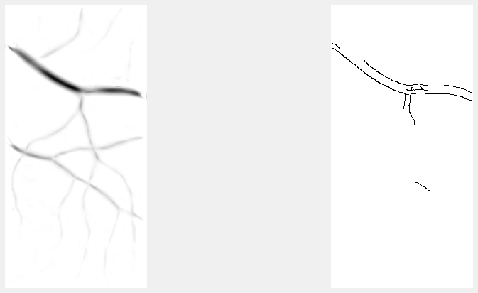

-0.00745


In [20]:
icanny = AFilter( skimage.feature.canny, {}, 'canny', mode=-1).apply(img.gray_float_array)

show_image_list([ifrangi, icanny])
print( icanny.mean() )